# Spatial analogues of canadian cities

The application's mechanics in a script-like notebook.

## Imports, constants, functions and data

In [19]:
# Imports
import cartopy.crs as crs
import cartopy.feature as cfeat
from collections import namedtuple
import dask
from dask.diagnostics import ProgressBar
import geopandas as gpd
from IPython.display import display_html
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import Point, LineString
import warnings
import xarray as xr
import xclim as xc
from xclim import analog as xa
# Following lines to limit warnings with shapely 1.8
# from shapely.erros import ShapelyDeprecationWarning
# warnings.simplefilter('ignore', ShapelyDeprecationWarning)

In [2]:
# constants
# Dask. To make this notebook slightly faster, change the "scheduler" argument to scheduler='processes' and num_workers=4 (for example)
dask.config.set(scheduler='single-threaded', temporary_directory='/notebook_dir/writable-workspace/tmp')

# Projection
biasadjust = 'single' # scaling or dqm the method used for the annual adjustment method


# Colors for the plots. Names colors are listed here: https://matplotlib.org/stable/gallery/color/named_colors.html 
fut_col = 'purple'     # The target city at the target period
hist_col = 'white'     # The target city at the reference period
ana_col = 'goldenrod'  # The best analog at the reference period

# Thresholds, names and colors for the different quality categories (lists must all be the same length)
quality_thresholds = [1, 5, 10, 100]  # Upper percentile associated with the category (reference distributions only go up to the 20th percentile)
quality_terms = ['Excellent', 'Good', 'Average', 'Poor']
quality_colors = ['lightgreen', 'lightyellow', 'bisque', 'lightcoral']

num_realizations = 12  ## Number of realization included in the results
best_analog_mode = 'closestPer'  # closestN or min, see below
num_bestanalogs = 10  # for closestN
per_bestanalogs = 1  # for closestPer
debug_mode = False  # For printing more information in the analogue selection cell

## Projected indices
Three versions of the simulated indices exist. The differences lie in the way the second adjustment was done. One can switch version by changing `biasadjust` (the data cell must be re-executed afterwards).

- 'single' : No second adjustment done.
- 'scaling' : A simple scaling (or offset for TNn, TG and TXx)
- 'dqm' : The same Detrended Quantile Mapping as the daily adjustment.

When a second adjustment was performed, some city/ssp couples were not adjusted. To avoid singularities in the scalings, the following conditions were checked:
- The 30 years of the reference are near zero (`max(ref) > mean(ref) * 500`)
- The 30 years of the simulated indices on the reference period are near zero on any of the realizations
- The standard deviation of the simulated indice over the 2071-2100 period is at least 5 times larget than the one of the reference period, for any of the realization.
If any of the above conditions was met, the timeseries were not re-adjusted.

## Reference distributions and quality flags
As part of the upstream data generation pipeline, reference dissimilarity distributions were computed.
For each indicator combination (from 1 to 4 indicators for a total of 6195 combinations), dissimilarity scores were computed for 200 000 couples taken randomly within the reference data. The percentiles of the resulting score distributions were saved to a file. Thus, we can compare a computed score to its corresponding reference  distribution and estimate its percentile by interpolating on the saved ones. The `quality_thresholds` are limits of (arbitrary) quality categories used to give an idea of the quality of the selected analogy.

One way of interpreting the estimated percentile is that it represent the probability of getting a better analogy by choosing another point randomly. It is similar in idea with the commonly used p-value. A major difference here is that the reference distribution is empirical, estimated through a Monte-Carlo method.

## Best analogue selection modes
The three best analogue selection methods are:

- `min`: The best analogue is the point with the lowest dissimilarity score.
- `closestN`: The best analogue is the closest point (in physical distance) to target city among the `num_bestanalogs` lowest dissimilarity scores.
- `closestPer`: The percentiles of all dissimilarity scores is found by interpolating the reference distributions. If the lowest percentile is `P_min`, then the best analogue is the closest point (in physical distance) to the target city among those with a percentile in the range `[P_min, P_min + per_bestanalogs]`.

A single best analogue is selected for each realization.

In [11]:
# functions
def open_thredds(url):
    """Open netCDF files on thredds and decode the string variables."""
    ds = xr.open_dataset(url, decode_timedelta=False)
    with xr.set_options(keep_attrs=True):
        for c in ds.variables.keys():  
            if ds[c].dtype == 'S64':
                ds[c] = ds[c].str.decode('latin1')
    return ds

def stack_drop_nans(ds, mask):
    """Stack dimensions into a single axis 'site' and drops indexes where the mask is false."""
    mask_1d = mask.stack(site=mask.dims)
    out = ds.stack(site=mask.dims).where(mask_1d, drop=True).reset_index('site')
    for dim in mask.dims:
        out[dim].attrs.update(ds[dim].attrs)
    return out.assign_coords(site=np.arange(out['site'].size))

def get_score_percentile(score, indices, benchmark):
    """Compare scores with the reference distribution for an indicator combination.
    Returns the interpolated percentiles.
    """
    dist = benchmark.sel(indices='_'.join(sorted(indices)))
    if isinstance(score, xr.DataArray):
        return xr.apply_ufunc(
            np.interp,
            score, dist, dist.percentiles,
            input_core_dims=[[], ['percentiles'], ['percentiles']],
            output_dtypes=[dissimilarity.dtype],
            dask='parallelized',
        )
    perc = np.interp(score, dist, benchmark.percentiles)
    return perc

def get_quality_flag(score=None, indices=None, benchmark=None, percentile=None):
    """Compute the percentiles of scores compared to the reference distribution
    and return the quality flag as defined above.
    """
    if percentile is None:
        percentile = get_score_percentile(score, indices, benchmark)
    q = np.searchsorted(quality_thresholds, percentile)
    if isinstance(score, xr.DataArray):
        return score.copy(data=q).rename('quality_flag')
    return q

def get_unusable_indices(iloc, ssp, tgt_period):
    """Return a set of indices that are not usable for this combination of city, scenario and target period.
    
    This simply tests that the standard deviation is null over any realization on the reference period or the target period,
    or over the reference.
    """
    city = cities.iloc[iloc]
    ref = (dref.sel(lat=city.geometry.y, lon=city.geometry.x).std('time') == 0)
    sim = dsim.isel(location=iloc, realization=slice(0, num_realizations)).sel(ssp=ssp)
    simh = (sim.sel(time=slice('1981', '2010')).std('time') == 0).any('realization')
    simf = (sim.sel(time=tgt_period).std('time') == 0).any('realization')
    with ProgressBar():
        simh, simf, ref = dask.compute(simh, simf, ref)
    return set(
        [name for name, var in simh.data_vars.items() if var]
    ).union(
        [name for name, var in simf.data_vars.items() if var]
    ).union(
        [name for name, var in ref.data_vars.items() if var]
    )

def get_distances(lon, lat, geom):
    df = gpd.GeoDataFrame(geometry=[Point(lo, la) for lo, la in zip(lon, lat)], crs=4326)
    return df.to_crs(epsg=8858).distance(geom).values

### Data sources
All the data is stored remotely, but some of it will be downloaded here to accelerate the computations.

The reference and simulated indices, the set of spatial masks and the reference distributions are all stored as netCDF files on Pavics' THREDDS server, while the list of target cities and the database of named places of North America are stored on Pavics' Geoserver instance.

In [ ]:
# Data
dref = open_thredds(
    'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/ouranos/spatial-analogs/era5-land.ncml'
).chunk({'time': -1}).sel(time=slice('1991', '2020'))

dsim = open_thredds(
    f'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/ouranos/spatial-analogs/cmip6_{biasadjust}.ncml'
)
dsim = xc.core.calendar.convert_calendar(dsim, 'default')

places = gpd.read_file(
    "https://pavics.ouranos.ca/geoserver/public/ows?"
    "service=wfs&version=2.0.0&request=GetFeature"
    "&typeName=public:ne_10m_populated_places&bbox=22,-170,83,-48"
    "&propertyname=NAME,ADM0_A3,ADM1NAME,the_geom&outputFormat=application/json"
).to_crs(epsg=8858)
#cities = gpd.read_file(
#    "https://pavics.ouranos.ca/geoserver/analogs/ows?"
#    "service=wfs&version=2.0.0&request=GetFeature"
#    "&typeName=analogs:cities"
#    "&propertyname=city,province,prov_code,density,the_geom&outputFormat=application/json"
#)
cities = gpd.read_file('cities_tmp.geojson')

masks = open_thredds('https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/ouranos/spatial-analogs/masks.nc')

benchmark = open_thredds(
    'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/ouranos/spatial-analogs/benchmarks.nc'
 ).benchmark.chunk()

density = masks.dens_adj.sel(year=2020).where(
    masks.roi & dref.isel(time=0).notnull().to_array().all('variable')
)

# Pre-compute/download the reference distributions and the density map
with ProgressBar():
    benchmark, density = dask.compute(benchmark, density)

[########################################] | 100% Completed |  4.1s


## Options
Configure the research.

Options are set through variables:
- `icity`: index of the target city within the `location` coord (common to the data files and `cities`), 0 to 64.
- `ssp`: `ssp245` or `ssp585`, the emission scenario's ID.
-  `tgt_period`: a slice of years (usually 30), 1990 to 2100
- `climate_indices`: a list of indicator names (variable names)
- `density_factor`: Factor to control the urban mask. For example, a value of 2 will include all reference points with densities ranging from half to the double of the target city's density. The lower bound is floored at a minimum density of 10 hab/km².

#### Notes
For some extreme indices, it's common to have only zeros in the reference period. As the dissimilarity method compares distributions and needs to compute the standard deviation, those cases are not usable with the current algorithm. The `get_unusable_indices` will return the list of thoses indices for a given combination of city, scenario and target period.

For example, in Iqaluit, Nunavut, the number of tropical nights (Tmin > 22°C, `TNgt22`) is zero in all simulations and scenarios for all years before 2070. This means that the standard deviation of the indicator distribution over the reference period is zero and it can't be used with the Zech-Aslan dissimilarity algorithm. 

Evidently, it's not only a matter of being unusable with the algorithm, but results would also be quite uninteresting since that indicator doesn't carry much information.

In [ ]:
# See possible values for options
print('`icity` values:')
for i, (city, prov) in enumerate(zip(cities.city, cities.prov_code)):
    print(f"{i} = {city}, {prov}")
print()
print('Climate indices:')
for key, var in dsim.data_vars.items():
    print(f"{key} = {var.long_name} ({var.units})")

`icity` values:
0 = Calgary, AB
1 = Edmonton, AB
2 = Red Deer, AB
3 = Lethbridge, AB
4 = Grande Prairie, AB
5 = Vancouver, BC
6 = Kelowna, BC
7 = Abbotsford, BC
8 = Victoria, BC
9 = Prince George, BC
10 = Winnipeg, MB
11 = Brandon, MB
12 = Steinbach, MB
13 = Thompson, MB
14 = Portage la Prairie, MB
15 = Moncton, NB
16 = Saint John, NB
17 = Fredericton, NB
18 = Dieppe, NB
19 = Miramichi, NB
20 = St. John's, NL
21 = Mount Pearl, NL
22 = Corner Brook, NL
23 = Happy Valley-Goose Bay, NL
24 = Labrador City, NL
25 = Halifax, NS
26 = Cape Breton - Sydney, NS
27 = Truro, NS
28 = New Glasgow, NS
29 = Glace Bay, NS
30 = Toronto, ON
31 = Ottawa, ON
32 = London, ON
33 = Sudbury, ON
34 = Moosonee, ON
35 = Charlottetown, PE
36 = Summerside, PE
37 = Stratford, PE
38 = Cornwall, PE
39 = Montague, PE
40 = Montréal, QC
41 = Québec, QC
42 = Sherbrooke, QC
43 = Saguenay, QC
44 = Chibougamau, QC
45 = Saskatoon, SK
46 = Regina, SK
47 = Prince Albert, SK
48 = Moose Jaw, SK
49 = Swift Current, SK
50 = Yellowk

In [ ]:
icity = 40
print(f'City : {cities.iloc[icity].city}, {cities.iloc[icity].density:.0f} hab/km²')
ssp = 'ssp245'
tgt_period = slice('2071', '2100')
print('You can\'t use the following indices:')
print(get_unusable_indices(icity, ssp, tgt_period))

City : Montréal, 8111 hab/km²
You can't use the following indices:
[########################################] | 100% Completed |  1.6s
set()


In [ ]:
climate_indices = ['TG', 'GDD0']
density_factor = 8

## Analogues search

1. Timeseries are extracted from the datasets. 

<div class="alert alert-info">
The code prints out the number of points that the urban mask contains (using the target's city density and the density factor). A larger value means the computation will take more time. The density factor should chosen so that at least 500 points are used. The maximum is around 20 000 (which will be quite slow).
</div>

2. The Zech Aslan metric is computed for all reference points respecting the density criterion
3. The best analogue is selected for each realization and associated summary information is extracted into the `analogs` list. The list is presented in descending order of performance (best analogies first).

In [ ]:
# Extract objects, get the mask of appropriate densities
city = cities.iloc[icity]

sim = dsim[climate_indices].isel(
    location=icity, realization=slice(0, num_realizations)
).sel(ssp=ssp)

mask = (density < (city.density * density_factor)) & (density > max(city.density / density_factor, 10))

ncell = mask.sum()
print(f'Found {int(ncell)} cells with appropriate density ({float(ncell / mask.notnull().sum()):.2%})')

ref = stack_drop_nans(dref[climate_indices], mask).chunk({'site': 100})

Found 515 cells with appropriate density (0.05%)


In [ ]:
%%time
# Compute the Zech-Aslan dissimiarity
# We also keep the simulated and reference timeseries in memory for the graphs.
# percentiles are computed for the `closestPer` method.
with ProgressBar():
    dissimilarity = xa.spatial_analogs(
        sim.sel(time=tgt_period).drop_vars(['lon', 'lat']), ref, dist_dim='time', method='zech_aslan'
    )
    simzscore = xa.spatial_analogs(
        sim_tgt.mean('realization'), sim_tgt, dist_dim='time', method='seuclidean'
    )
    percs = get_score_percentile(dissimilarity, climate_indices, benchmark)
    sim, ref, dissimilarity, percs, simzscore = dask.compute(sim, ref, dissimilarity, percs, simzscore)

[########################################] | 100% Completed |  7.7s
CPU times: user 3.94 s, sys: 1.63 s, total: 5.57 s
Wall time: 7.73 s


In [12]:
# For each realization, select the best analogue according to the selected "best_analog_mode"
analogs = []
for real in dissimilarity.realization:
    diss = dissimilarity.sel(realization=real)
    perc = percs.sel(realization=real)
    with ProgressBar():
        if best_analog_mode == 'min':
            i = diss.argmin().item()
        elif best_analog_mode == 'closestN':
            diss = diss.sortby(diss).isel(site=slice(None, num_bestanalogs))
            dists = get_distances(diss.lon, diss.lat, city.geometry)
            i = dists.argmin()
        elif best_analog_mode == 'closestPer':
            perc_min = perc.min()
            diss = diss.where(perc < perc_min + per_bestanalogs, drop=True)
            diss = diss.sortby(diss)
            dists = get_distances(diss.lon, diss.lat, city.geometry)
            i = dists.argmin()

    score = diss.isel(site=i)
    percentile = get_score_percentile(score.item(), climate_indices, benchmark)
    qflag = get_quality_flag(percentile=percentile)
    analogs.append(
        dict(
            simulation=real.item(),
            site=score.site.item(),
            zscore=simzscore.sel(realization=real).item(),
            inner_rank=i,
            density=density.sel(lon=score.lon, lat=score.lat).item(),
            score=score.item(),
            percentile=percentile,
            qflag=qflag,
            quality=quality_terms[qflag],
            geometry=Point(score.lon.item(), score.lat.item())
        )
    )

analogs = gpd.GeoDataFrame.from_records(analogs).sort_values('score').reset_index(drop=True).set_crs(epsg=4326)
analogs.index.name = 'rank'
analogs

,simulation,site,inner_rank,density,score,percentile,qflag,quality,geometry
rank,,,,,,,,,
0,NOAA-GFDL_GFDL-ESM4,261,0,1050.089844,-0.038836,0.995805,0,Excellent,POINT (-86.20000 41.70000)
1,MIROC_MIROC-ES2L,292,0,1133.072021,-0.036170,0.998780,0,Excellent,POINT (-85.10000 41.10000)
2,CMCC_CMCC-ESM2,394,6,1258.579590,-0.018163,1.756049,1,Good,POINT (-86.30000 39.80000)
3,EC-Earth-Consortium_EC-Earth3-Veg-LR,284,1,1512.596436,-0.008317,2.206468,1,Good,POINT (-96.00000 41.30000)
4,IPSL_IPSL-CM6A-LR,375,3,1071.100952,-0.007983,2.222175,1,Good,POINT (-83.10000 40.00000)
5,MPI-M_MPI-ESM1-2-LR,261,5,1050.089844,-0.003350,2.440176,1,Good,POINT (-86.20000 41.70000)
6,MIROC_MIROC6,261,3,1050.089844,0.002300,2.705983,1,Good,POINT (-86.20000 41.70000)
7,CCCma_CanESM5,394,6,1258.579590,0.004544,2.811557,1,Good,POINT (-86.30000 39.80000)
8,NIMS-KMA_KACE-1-0-G,375,3,1071.100952,0.009606,3.049673,1,Good,POINT (-83.10000 40.00000)


## Results for a given analog

For each realization, two figures and a table are displayed in order to evaluate the analog performance. A map is also given showing the currently the target, the selected analogue and the other realization's analogs.

In the notebook, the selection of the realization to analyze is done by setting `analog` to one element of `analogs`.

### Dissimilarity score
The Zech-Aslan dissimilarity metric gives an idea of how similar two multivariate distributions are. The score goes from $-\infty$ (identical distributions) to $\infty$, but results are usually around 0. It must emphasized that the scale of the scores is **unique to the set of indicators being analyzed**.  This is why we introduced the reference distributions, percentiles and quality categories, as explained above.

In [14]:
analog = analogs.iloc[1]
print(f'Showing results for {analog.simulation} (Goodness of analogy score : {analog.score:.3f}, {analog.quality})')

Showing results for MIROC_MIROC-ES2L (Goodness of analogy score : -0.036, Excellent)


### Univariate analogies
This graph deconstructs the multivariate score into its components, i.e. the dissimilarity for each climate indicator individually. On the left, the score and quality of the analogy taken for each indicator is shown. As said above, the dissimilarity score can't be compared between different indicators, this is the role intended for the percentiles and quality flags.

On the right, the indicator averages are shown in a 1D graph. The stars show the average of the target city : coloured for the target period and blank (centered) for the reference period. The circle shows the average over the reference period of the selected analogue. This graph is meant to give an idea of how much the general climate has changed between the reference and target periods. The dissimilarity metric compares distributions, here the points show the mean. The pale lines in the background divide the range by standard deviations computed from the reference period's distribution of the target.

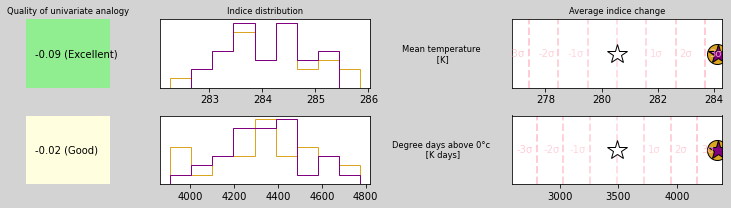

In [16]:
# Goodness-of-analogy graphs
fig, axs = plt.subplots(
    len(climate_indices), 4, figsize=(10, 3), facecolor='lightgrey',
    gridspec_kw={'width_ratios': [2, 5, 1, 5]}
)
if len(climate_indices) == 1:
    axs = axs.reshape(1, 3)

for climind, (axF, axD, axT, ax) in zip(climate_indices, axs):
    ref_dist = ref[climind].sel(site=analog.site)
    ref_mean = ref_dist.mean().item()
    hist_dist = sim[climind].sel(realization=analog.simulation, time=slice('1991', '2020'))
    hist_mean = hist_dist.mean().item()
    hist_std = hist_dist.std().item()
    sim_dist = sim[climind].sel(realization=analog.simulation, time=tgt_period)
    sim_mean = sim_dist.mean().item()
    
    vmin = min(hist_mean - 3 * hist_std, ref_mean, sim_mean)
    vmax = max(hist_mean + 3 * hist_std, ref_mean, sim_mean, 2 * hist_mean - vmin)
    vmin = 2 * hist_mean - vmax
    
    spacer = (vmax - vmin) / 50
    
    #ax.hlines(1, vmin, vmax)
    ax.set_xlim(vmin - spacer, vmax + spacer)
    ax.set_ylim(0.9, 1.1)
    
    for n in range(-3, 4):
        ax.axvline(
            hist_mean + n * hist_std, color='pink',
            linestyle='--', linewidth=2, alpha=0.5 + 0.1 * abs(n)
        )
        if n != 0:
            ax.text(
                hist_mean + n * hist_std + np.sign(n) * spacer, 1, f'{n}σ',
                color='pink', alpha=0.5 + 0.1 * abs(n), va='center', ha='left' if n > 0 else 'right'
            )
    
    ax.plot([ref_mean], [1], 'o', color=ana_col, markersize=20, markeredgecolor='k')
    ax.plot([hist_mean], [1], '*', color=hist_col, markersize=20, markeredgecolor='k')
    ax.plot([sim_mean], [1], '*', color=fut_col, markersize=20, markeredgecolor='k')
    
    #if abs(hist_mean - ref_mean) > hist_std:
    #    ax.set_xticks([ref_mean, hist_mean])
    #else:
    #    ax.set_xticks([hist_mean])
    ax.set_yticks([])
    
    uni_score = xa.zech_aslan(sim_dist, ref_dist)
    qflag = get_quality_flag(uni_score, [climind], benchmark)
    axF.text(0.1, 0.5, f"{uni_score: 5.2f} ({quality_terms[qflag]})", ha='left', va='center')
    axF.set_xticks([]); axF.set_yticks([])
    axF.set_facecolor(quality_colors[qflag])
    [s.set_visible(False) for s in axF.spines.values()]

    long_name = sim[climind].long_name.replace('(', '\n(')
    if '\n' not in long_name:
        long_name = long_name + '\n'
    axT.text(0.5, 0.5, f"{long_name} [{sim[climind].units}]", ha='center', va='center', fontsize='small')
    axT.set_axis_off()
    
    vmin = min(ref_dist.min(), sim_dist.min())
    vmax = max(ref_dist.max(), sim_dist.max())
    ref_dist.plot.hist(ax=axD, bins=np.linspace(vmin, vmax, 10), histtype='step', color=ana_col)
    # hist_dist.plot.hist(ax=axD, bins=np.linspace(vmin, vmax, 10), histtype='step', color='k')
    sim_dist.plot.hist(ax=axD, bins=np.linspace(vmin, vmax, 10), histtype='step', color=fut_col)
    axD.set_title('')
    axD.set_yticks([])
    axD.set_ylabel('')
    axD.set_xlabel('')

axs[0, 0].set_title("Quality of univariate analogy", fontsize='small')
axs[0, 3].set_title("Average indice change", fontsize='small')
axs[0, 1].set_title("Indice distribution", fontsize='small')
fig.tight_layout()

### Univariate timeseries
For each analyzed climate indicator, the full annual timeseries is shown. The target's timeseries for the currently selected realization is shown in purple, all other realizations (for the same point) are in light gray. The currently selected best analogue's timeseries over the 30 year of the reference period is in gold and is duplicated over the target period so it's easier to assess the distributions similarity. The vertical lines show the target period.

It must be noted that the Zech-Aslan metric makes no use of the temporal information. Thus, a good analogy doesn't need the timeseries to look similar, but rather that the 30 annual values are distributed in the same way.

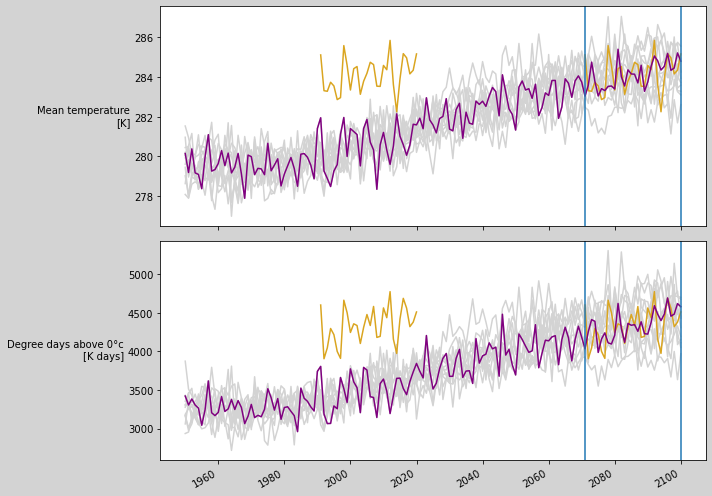

In [17]:
# Timeseries plot
fig, axs = plt.subplots(len(climate_indices), 1, figsize=(10, 7), facecolor='lightgrey', sharex=True)
if len(climate_indices) == 1:
    axs = [axs]

for climind, ax in zip(climate_indices, axs):        
    tgt = sim.sel(time=tgt_period, realization=analog.simulation)

    sim[climind].plot(hue='realization', ax=ax, color='lightgrey', add_legend=False)
    refts = ref[climind].sel(site=analog.site)
    refts.plot(ax=ax, color=ana_col)
    if int(tgt_period.start) >= 2020:
        refts['time'] = tgt.time
        refts.plot(ax=ax, color=ana_col)
    sim[climind].sel(realization=analog.simulation).plot(ax=ax, color=fut_col)

    ax.axvline(tgt.indexes['time'][0])
    ax.axvline(tgt.indexes['time'][-1])
    ax.set_title('')
    
    long_name = sim[climind].long_name.replace('(', '\n(')
    ax.set_ylabel(
        f"{long_name}\n[{sim[climind].units}]",
        rotation='horizontal', ha='right', va='center'
    )
    ax.set_xlabel('')
fig.tight_layout()

### Map of selected analogues
This simple map shows the target city with a star and the currently selected best analogue with a gold cirle. All found analogues (all realizations) are shown with lines originating from the target.

All candidate points (gridcells with a density within the specified range) are shown in light red.

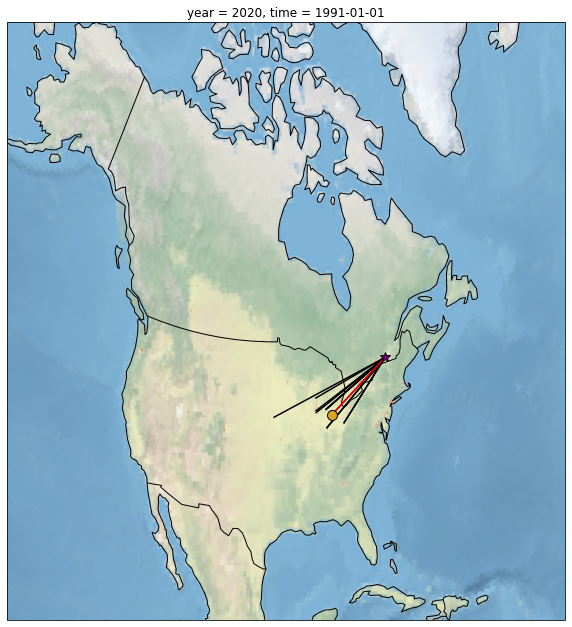

In [23]:
# Map
analogs_lines = gpd.GeoDataFrame(
    analogs.drop(columns=['geometry']),
    geometry=[LineString([a.geometry, city.geometry]) for i, a in analogs.iterrows()],
    crs=analogs.crs,
)
show_candidates = True

fig, ax = plt.subplots(figsize=(10, 12), subplot_kw={'projection': crs.LambertConformal()})
ax.stock_img()
ax.add_feature(cfeat.COASTLINE)
ax.add_feature(cfeat.BORDERS)

if show_candidates:
    mask.where(mask).plot(
        ax=ax, alpha=0.3, cmap=plt.cm.Reds, transform=crs.PlateCarree(), add_colorbar=False
    )
    
analogs_lines.plot(ax=ax, color='k', transform=crs.PlateCarree())
analogs_lines.loc[[analog.name]].plot(ax=ax, color='red', transform=crs.PlateCarree())
ax.plot(city.geometry.x, city.geometry.y, '*', markersize=10, markeredgecolor='k', color=fut_col, transform=crs.PlateCarree())
ax.plot(analog.geometry.x, analog.geometry.y, 'o', markersize=10, markeredgecolor='k', color=ana_col, transform=crs.PlateCarree());
ax.set_extent([-135, -53, 20, 75], crs=crs.PlateCarree())

### Summary table
On the left column, information from the chosen target and on the right, information from the currently selected analogue.

In [22]:
# Table
ana_df = analogs.loc[[analog.name]].to_crs(epsg=8858)
distances = places.distance(ana_df.geometry.iloc[0])
near_city = places.iloc[distances.argmin()].copy()
near_dist = ana_df.distance(cities.loc[[city.name]].to_crs(epsg=8858).geometry.iloc[0]).iloc[0] / 1000

if near_city.ADM0_A3 in ['USA', 'CAN']:
    near_city['fullname'] = f"{near_city['NAME']}, {near_city['ADM1NAME']}"
else:
    near_city['fullname'] = f"{near_city['NAME']}, {near_city['ADM0_A3']}"

def dec2sexa(num, secfmt='02.0f'):
    deg = int(num)
    minu = int((num - deg) * 60)
    sec = (num - deg - (minu / 60)) * 3600
    return f"{deg}°{minu:02.0f}′{sec:{secfmt}}″"

table = """
<table>
  <tr>
    <th> <span style="font-size: large;color: {fut_col}";>&#9733;</span> Target </th>
    <th> <span style="font-size: large;color: {ana_col};">&#9679;</span> Highlighted analog </th>
  </tr>
  <tr> <td>{tgt_name}</td><td>near: {ana_name} ({ana_dist:.0f} km)</td> </tr>
  <tr>
    <td>{tgt_lat}N,  {tgt_lon}W</td><td>{ana_lat}N,  {ana_lon}W</td>
  </tr>
  <tr>
    <td> Projection for {tgt_period.start}-{tgt_period.stop} <br> {sim} / {ssp} </td>
    <td> Normals 1991-2020 <br> ERA5-Land </td>
  </tr>
  <tr>
    <td> Pop. density (2020): {tgt_density:.0f} hab./km² </td>
    <td> Pop. density (2020): {ana_density:.0f} hab./km² </td>
  </tr>
</table>
"""
table_html = table.format(
    fut_col=mpl.colors.get_named_colors_mapping()[fut_col],
    ana_col=mpl.colors.get_named_colors_mapping()[ana_col],
    tgt_name=f"{city.city}, {city.prov_code}",
    tgt_lat=dec2sexa(city.geometry.y),
    tgt_lon=dec2sexa(-city.geometry.x),
    tgt_density=city.density.item(),
    ana_name=near_city.fullname,
    ana_lat=dec2sexa(analog.geometry.y),
    ana_lon=dec2sexa(-analog.geometry.x),
    ana_dist=near_dist,
    ana_density=analog.density,
    sim=analog.simulation,
    tgt_period=tgt_period,
    ssp=f"SSP{ssp[3]}-{ssp[4]}.{ssp[5]}",
)

display_html(table_html, raw=True)

★ Target,● Highlighted analog
"Montréal, QC","near: Fort Wayne, Indiana (1045 km)"
"45°30′00″N, 73°35′60″W","41°05′60″N, 85°05′60″W"
Projection for 2071-2100 MIROC_MIROC-ES2L / SSP2-4.5,Normals 1991-2020 ERA5-Land
Pop. density (2020): 8111 hab./km²,Pop. density (2020): 1133 hab./km²
